In [1]:
#@title Library  { form-width: "30%" }
import tensorflow.keras as keras
from scipy.stats import entropy
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import roc_curve
import matplotlib 
matplotlib.use('agg')
import matplotlib.pyplot as plt 
import pandas as pd 
from scipy.fft import fft
from scipy.stats import gennorm
import numpy as np
from scipy.special import gamma
import math
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense,LSTM
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from scipy.signal import savgol_filter
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
!pip install -q -U tensorflow-addons
!pip install keras-tcn
# from utils.utils import save_logs
# from utils.utils import calculate_metrics

In [2]:
#@title DATA  { form-width: "30%" }
def find_energy(signal, snr):
  Y = fft(signal)
  abs_Y = abs(Y)**2
  r = np.mean(abs_Y)
  return 2*snr*np.sum(r)
def find_de(signal,beta):
  alpha = np.log(beta*(np.sum(abs(signal-np.mean(signal))**beta))/len(signal))/beta
  return 1/beta - np.log(beta/(2*math.gamma(1/beta))) + alpha
def find_gp(signal):
  return np.exp(np.mean(np.log(abs(np.array(signal)))))
def find_lp(signal,p):
  lp = np.mean(abs(signal)**p)
  return lp 
def normalizeData(raw_data):
  data = (raw_data - np.mean(raw_data))/np.sqrt(np.var(raw_data))
  return data

batch = 50
df = pd.read_csv(r"D:\Spectrum-Sensing-master\Datasets\dataset3.csv")
raw_data = df.iloc[:,0]
raw_data = raw_data.to_numpy()
signal = normalizeData(raw_data[0:50000])
lenSample = len(signal)
# beta = 1.5
TIME_PERIODS = 1

def createTrainTest(data,Features):
  x = data[:,0:Features]
  y = data[:,-1]
  return x,y

def createFeature(beta,snrDB,p=0.5):
  var = 1
  alpha = np.sqrt((var*gamma(1/beta))/(gamma(3/beta)))
  
  snr = 10**(snrDB/10);
  featuresMatrix = np.zeros(shape=(2000,5))
 
  for i in range(0,lenSample,batch): 
    if i+batch <= lenSample:
      noise = gennorm.rvs(beta, size=batch,scale = alpha)
      
      h1 = noise + np.sqrt(snr)*signal[i:i+batch]
      h0 = gennorm.rvs(beta, size=batch,scale = alpha)
      # features for h1
      energy = find_energy(h1,snr)
      de = find_de(h1,beta)
      gp = find_gp(h1)
      lp = find_lp(h1,p)
      
      featuresMatrix[i//batch] = [gp,de,lp,energy,1]
      
      # features for h0
      energy = find_energy(h0,snr)
      de = find_de(h0,beta)
      gp = find_gp(h0)
      lp = find_lp(h0,p)
      
      featuresMatrix[(lenSample+i)//batch] = [gp,de,lp,energy,0]
      

  featuresMatrix[:,0] = featuresMatrix[:,0]/max(featuresMatrix[:,0])
  featuresMatrix[:,1] = featuresMatrix[:,1]/max(featuresMatrix[:,1])
  featuresMatrix[:,2] = featuresMatrix[:,2]/max(featuresMatrix[:,2])
  featuresMatrix[:,3] = featuresMatrix[:,3]/max(featuresMatrix[:,3])

  np.random.shuffle(featuresMatrix)

  return featuresMatrix

def findPd(pf,pd):
  temp = np.where((pf<=0.1) & (pf>0.0))[0]
  if temp.size>0 and pd[temp[-1]] != 0.0:
    return pd[temp[-1]]
  else:
    return 1.0

In [36]:
snrDB = np.flip(np.arange(-20,25,5))

beta = 1

pd_cnn = np.ones(len(snrDB))
pd_mlp = np.ones(len(snrDB))
pd_fcn = np.ones(len(snrDB))
pd_rnet =np.ones(len(snrDB))
pd_lstm =np.ones(len(snrDB))
pd_tcn = np.ones(len(snrDB))

num_time_periods = 1
num_classes = 1
num_sensors=4

In [4]:
#@title MLP  { form-width: "30%" }
# input_layer = keras.layers.Input(num_sensors,)

# # flatten/reshape because when multivariate all should be on the same axis 
# input_layer_flattened = keras.layers.Flatten()(input_layer)

# # layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
# layer_1 = keras.layers.Dense(500, activation='relu')(input_layer_flattened)

# # layer_2 = keras.layers.Dropout(0.2)(layer_1)
# layer_2 = keras.layers.Dense(500, activation='relu')(layer_1)

# # layer_3 = keras.layers.Dropout(0.2)(layer_2)
# layer_3 = keras.layers.Dense(500, activation='relu')(layer_2)

# # output_layer = keras.layers.Dropout(0.3)(layer_3)
# output_layer = keras.layers.Dense(1, activation='sigmoid')(layer_3)

# model_mlp = keras.models.Model(inputs=input_layer, outputs=output_layer)

# model_m.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model_mlp = Sequential()
model_mlp.add(keras.Input(shape=(num_sensors,)))
# model_mlp.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
# model_mlp.add(Dense(3,activation='relu'))
model_mlp.add(Dense(100,activation='relu'))
model_mlp.add(Dense(100,activation='relu'))
model_mlp.add(Dense(100,activation='relu'))
model_mlp.add(Dense(1,activation='sigmoid'))
# print(model_mlp.summary())



In [5]:
#@title CNN  { form-width: "30%" }
model_cnn = Sequential()
model_cnn.add(Reshape((num_sensors, 1), input_shape=(num_sensors,)))
model_cnn.add(Conv1D(50, 1, activation='relu', input_shape=(num_sensors,1)))
model_cnn.add(Conv1D(50, 1, activation='relu'))
model_cnn.add(MaxPooling1D(1))
model_cnn.add(Dense(50,activation='relu'))
model_cnn.add(Dense(50,activation='relu'))
model_cnn.add(GlobalAveragePooling1D())
model_cnn.add(Dense(num_classes, activation='sigmoid'))
model_cnn.save('CNN.h5')
print(model_cnn.summary())
# from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 4, 1)              0         
                                                                 
 conv1d (Conv1D)             (None, 4, 50)             100       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 50)             2550      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 50)            0         
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 4, 50)             2550      
                                                                 
 dense_5 (Dense)             (None, 4, 50)             2550      
                                                      

In [6]:
#@title RESNET  { form-width: "30%" }
n_feature_maps = 50

input_layer = keras.layers.Input(num_sensors,)

# BLOCK 1
reshape = keras.layers.Reshape((1,num_sensors), input_shape=(num_sensors,))(input_layer)
conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(reshape)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(reshape)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_2 = keras.layers.add([shortcut_y, conv_z])
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)

output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)

# FINAL

gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

output_layer = keras.layers.Dense(1, activation='sigmoid')(gap_layer)

model_rnet = keras.models.Model(inputs=input_layer, outputs=output_layer)
model_rnet.save('RNET.h5')
# model_m.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [7]:
#@title LSTM  { form-width: "30%" }

from keras.regularizers import l2
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time


N = num_sensors                 # number of features
EPOCH = 50                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

model_lstm = Sequential()
model_lstm.add(Reshape((1,num_sensors), input_shape=(num_sensors,)))
model_lstm.add(LSTM(input_shape=(1,num_sensors), units=8,
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(units=8,
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(units=8,
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(units=1, activation='sigmoid'))
model_lstm.save('LSTM.h5')
# model_m.summary()
from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [8]:
#@title encoder  { form-width: "30%" }
# import tensorflow.keras as keras
# import tensorflow as tf
# import tensorflow_addons as tfa
# import numpy as np
# import time

# input_layer = keras.layers.Input(3,)
# reshape = keras.layers.Reshape((1, 3), input_shape=(3,))(input_layer)
# # conv block -1
# conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(reshape)
# conv1 = tfa.layers.InstanceNormalization()(conv1)
# conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
# conv1 = keras.layers.Dropout(rate=0.2)(conv1)
# conv1 = keras.layers.MaxPooling1D(pool_size=1)(conv1)
# # conv block -2
# conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
# conv2 = tfa.layers.InstanceNormalization()(conv2)
# conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
# conv2 = keras.layers.Dropout(rate=0.2)(conv2)
# conv2 = keras.layers.MaxPooling1D(pool_size=1)(conv2)
# # conv block -3
# conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
# conv3 = tfa.layers.InstanceNormalization()(conv3)
# conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
# conv3 = keras.layers.Dropout(rate=0.2)(conv3)
# # split for attention
# attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
# attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
# # attention mechanism
# attention_softmax = keras.layers.Softmax()(attention_softmax)
# multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
# # last layer
# dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
# dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
# # output layer
# flatten_layer = keras.layers.Flatten()(dense_layer)
# output_layer = keras.layers.Dense(units=1,activation='sigmoid')(flatten_layer)

# model_m = keras.models.Model(inputs=input_layer, outputs=output_layer)
# model_m.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [9]:
#@title FCN  { form-width: "30%" }
input_layer = keras.layers.Input(num_sensors,)
reshape = keras.layers.Reshape((1, num_sensors), input_shape=(num_sensors,))(input_layer)
conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(reshape)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activation='relu')(conv1)

conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)

conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)

gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

output_layer = keras.layers.Dense(1, activation='sigmoid')(gap_layer)

model_fcn = keras.models.Model(inputs=input_layer, outputs=output_layer)
model_fcn.save('FCN.h5')

In [10]:
#@title TCN
from tcn import compiled_tcn
from tcn import TCN, tcn_full_summary

model_tcn = compiled_tcn(return_sequences=False,
                         num_feat=1,
                         num_classes=2,
                         nb_filters=20,
                         kernel_size=6,
                         dilations=[2 ** i for i in range(9)],
                         nb_stacks=1,
                         max_len=num_sensors,
                         use_weight_norm=True,
                         use_skip_connections=True)
model_tcn.save('TCN.h5')
# model_tcn.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to m

x.shape= (None, 20)
model.x = (None, 4, 1)
model.y = (None, 2)


C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
#@title Model train/test  { form-width: "30%" }
def trainingModel(model,tcn=False):
  if tcn:
    model.compile(
    loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

    # Hyper-parameters
    BATCH_SIZE = 200
    EPOCHS = 5

    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model.fit(x_train,
                          y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,

                          validation_split=0.2,
                          verbose=0
                          )
    y_pred = model.predict(x_test)

    y_pred2=[]
    for i in y_pred:
      # print(i[0])
      if(i[0]>i[1]):
        y_pred2.append(i[1])
      else:
        y_pred2.append(i[1])
    y_test2=[]
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_pred2)
    return fpr_keras,tpr_keras

  # callbacks_list = [
  #     keras.callbacks.ModelCheckpoint(
  #         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
  #         monitor='val_loss', save_best_only=True),
  #     keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
  # ]

  model.compile(
      loss='binary_crossentropy',
                  optimizer='adam', metrics=['binary_accuracy'])

  # Hyper-parameters
  BATCH_SIZE = 10
  EPOCHS = 10

  # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
  history = model.fit(x_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                
                        validation_split=0.2,
                        verbose=0
                        )
  accuracy_results = model.evaluate(x_test, y_test)
  print("Accuracy :",accuracy_results)
  # %%

  # print("\n--- Learning curve of model training ---\n")

  # # summarize history for accuracy and loss
  # plt.figure(figsize=(6, 4))
  # plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
  # plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
  # plt.plot(history.history['loss'], "r--", label="Loss of training data")
  # plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
  # plt.title('Model Accuracy and Loss')
  # plt.ylabel('Accuracy and Loss')
  # plt.xlabel('Training Epoch')
  # plt.ylim(0)
  # plt.legend()
  # plt.show()

  #%%

  
  # y_test = np_utils.to_categorical(y_test, num_classes)

  # %%

  # print("\n--- Confusion matrix for test data ---\n")

  # y_pred_test = model_m.predict(x_test)
  # # Take the class with the highest probability from the test predictions
  # max_y_pred_test = np.argmax(y_pred_test, axis=1)
  # max_y_test = np.argmax(y_test, axis=1)

  # show_confusion_matrix(max_y_test, max_y_pred_test)

  # # %%

  # print("\n--- Classification report for test data ---\n")

  # print(classification_report(max_y_test, max_y_pred_test))
  
  # x_test, y_test = create_segments_and_labels(df_test,
  #                                             TIME_PERIODS,
  #                                             STEP_DISTANCE,
  #                                             'LABEL')
  # x_test = x_test.reshape(x_test.shape[0], input_shape)
  y_pred = model.predict(x_test)
  # if accuracy_results[1]<0.5:
  #   y_pred = 1-y_pred
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_pred)
  # plt.figure(1)
  # plt.plot(fpr_keras, tpr_keras)
  # plt.xlabel('False positive rate')
  # plt.ylabel('True positive rate')
  # plt.title('ROC curve')
  # plt.legend(loc='best')
  # plt.show()

  return fpr_keras,tpr_keras

In [18]:

def findPf(pf, pd):
    temp = np.where((pf <= 0.1) & (pf > 0.0))[0]
    if temp.size > 0 and pd[temp[-1]] != 0.0:
        return 1 - pd[temp[-1]]
    else:
        return 0.0

# KNN model

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
pd_knn=np.ones(len(snrDB))
pf_knn=np.ones(len(snrDB))
for i in range(len(snrDB)):
  
  featuresMatrix=createFeature(beta,snrDB[i])

  df_train,df_test = train_test_split(featuresMatrix, test_size=0.2, random_state=42)
  x_train, y_train = createTrainTest(df_train,num_sensors)
  x_test, y_test = createTrainTest(df_test,num_sensors)

  input_shape = (num_time_periods*num_sensors)
  
  x_train = x_train.reshape(x_train.shape[0], input_shape)
  
  x_train = x_train.astype("float32")
  y_train = y_train.astype("float32")

  x_test = x_test.reshape(x_test.shape[0], input_shape)

  x_test = x_test.astype("float32")
  y_test = y_test.astype("float32")
  print(snrDB[i])
  model_knn  = KNeighborsClassifier(n_neighbors=20);
  model_knn.fit(x_train, y_train)
  y_pred = model_knn.predict_proba(x_test)[: ,1]
  fpr_knn, tpr_knn, _ = roc_curve(y_test,y_pred,pos_label=1)
  pd_knn[i]=findPd(fpr_knn,tpr_knn)
  precision_knn=precision_score(y_test,y_pred.round())
  recall_knn=recall_score(y_test,y_pred.round())
  print("Accuracy is",model_knn.score(x_test,y_test))
  print("probablity of detection is ",pd_knn[i])
  print("precision is",precision_knn)
  print("recall is",recall_knn)
    


20
Accuracy is 1.0
probablity of detection is  1.0
precision is 1.0
recall is 1.0
15
Accuracy is 1.0
probablity of detection is  1.0
precision is 1.0
recall is 1.0
10
Accuracy is 1.0
probablity of detection is  1.0
precision is 1.0
recall is 1.0
5
Accuracy is 1.0
probablity of detection is  1.0
precision is 1.0
recall is 1.0
0
Accuracy is 0.9475
probablity of detection is  0.9521531100478469
precision is 0.9607843137254902
recall is 0.937799043062201
-5
Accuracy is 0.7875
probablity of detection is  0.6728971962616822
precision is 0.8208955223880597
recall is 0.7710280373831776
-10
Accuracy is 0.6675
probablity of detection is  0.22340425531914893
precision is 0.6486486486486487
recall is 0.6382978723404256
-15
Accuracy is 0.5525
probablity of detection is  0.09569377990430622
precision is 0.5925925925925926
recall is 0.45933014354066987
-20
Accuracy is 0.525
probablity of detection is  0.05612244897959184
precision is 0.5157894736842106
recall is 0.5


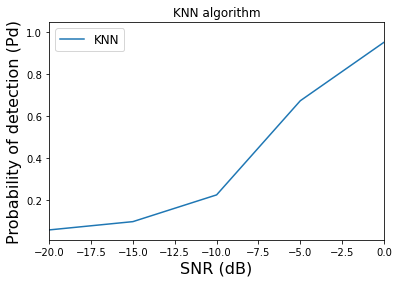

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [88]:
%matplotlib inline
fig = plt.figure()
# plt.plot(snrDB,pd_rnet,label = 'ResNet')
# plt.plot(snrDB,pd_lstm,label = 'LSTM')
plt.plot(snrDB,pd_knn,label = 'KNN')
plt.xlim([-20,0])
plt.xlabel('SNR (dB)',fontsize=16)
plt.ylabel('Probability of detection (Pd)',fontsize=16)
plt.title("KNN algorithm")
plt.legend(fontsize=12)
plt.show()
fig.savefig('raw.eps')


# SVM model

In [79]:
from sklearn import svm
from sklearn.metrics import confusion_matrix

pd_svm = np.ones(len(snrDB))
for i in range(len(snrDB)):
  
  featuresMatrix=createFeature(beta,snrDB[i])

  df_train,df_test = train_test_split(featuresMatrix, test_size=0.2, random_state=42)
  x_train, y_train = createTrainTest(df_train,num_sensors)
  x_test, y_test = createTrainTest(df_test,num_sensors)

  
  input_shape = (num_time_periods*num_sensors)
  
  x_train = x_train.reshape(x_train.shape[0], input_shape)
  
  x_train = x_train.astype("float32")
  y_train = y_train.astype("float32")

  x_test = x_test.reshape(x_test.shape[0], input_shape)

  x_test = x_test.astype("float32")
  y_test = y_test.astype("float32")
  model_svm = svm.SVC(kernel = 'linear')
  model_svm.fit(x_train, y_train)
  y_pred = model_svm.decision_function(x_test) 
  fpr_svm, tpr_svm, thresholds_keras = roc_curve(y_test,y_pred)
  pd_svm[i]=findPd(fpr_svm,tpr_svm)
  precision_svm=precision_score(y_test,y_pred.round(),pos_label='positive',average='micro')
  recall_svm=recall_score(y_test,y_pred.round(),pos_label='positive',average='micro')
  print(snrDB[i])
  print("Accuracy is",model_svm.score(x_test,y_test))
  print("probablity of detection is ",pd_svm[i])
  print("precision is",precision_svm)
  print("recall is",recall_svm)
 

C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


20
Accuracy is 1.0
probablity of detection is  1.0
precision is 0.1425
recall is 0.1425


C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


15
Accuracy is 1.0
probablity of detection is  1.0
precision is 0.17
recall is 0.17


C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


10
Accuracy is 1.0
probablity of detection is  1.0
precision is 0.0675
recall is 0.0675


C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


5
Accuracy is 1.0
probablity of detection is  1.0
precision is 0.05
recall is 0.05


C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


0
Accuracy is 0.9575
probablity of detection is  0.9794871794871794
precision is 0.1275
recall is 0.1275


C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


-5
Accuracy is 0.845
probablity of detection is  0.7591623036649214
precision is 0.2975
recall is 0.2975


C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


-10
Accuracy is 0.67
probablity of detection is  0.3181818181818182
precision is 0.405
recall is 0.405


C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


-15
Accuracy is 0.5975
probablity of detection is  0.20304568527918782
precision is 0.3825
recall is 0.3825
-20
Accuracy is 0.5675
probablity of detection is  0.16097560975609757
precision is 0.4025
recall is 0.4025


C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


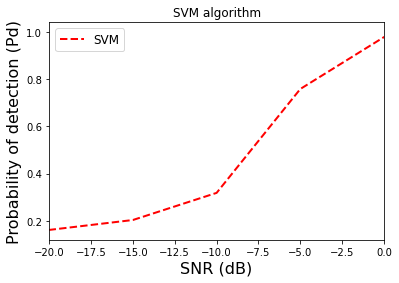

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [90]:
%matplotlib inline
fig = plt.figure()
# plt.plot(snrDB,pd_rnet,label = 'ResNet')
# plt.plot(snrDB,pd_lstm,label = 'LSTM')
plt.plot(snrDB,pd_svm,label = 'SVM',linestyle="dashed",linewidth='2',c='r')
plt.xlim([-20,0])
plt.xlabel('SNR (dB)',fontsize=16)
plt.ylabel('Probability of detection (Pd)',fontsize=16)
plt.title("SVM algorithm")
plt.legend(fontsize=12)
plt.show()
fig.savefig('raw.eps')

# LogisticRegression

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

pd_lr = np.ones(len(snrDB))
for i in range(len(snrDB)):
  
  featuresMatrix=createFeature(beta,snrDB[i])

  df_train,df_test = train_test_split(featuresMatrix, test_size=0.2, random_state=42)
  x_train, y_train = createTrainTest(df_train,num_sensors)
  x_test, y_test = createTrainTest(df_test,num_sensors)

  
  input_shape = (num_time_periods*num_sensors)
  
  x_train = x_train.reshape(x_train.shape[0], input_shape)
  
  x_train = x_train.astype("float32")
  y_train = y_train.astype("float32")

  x_test = x_test.reshape(x_test.shape[0], input_shape)

  x_test = x_test.astype("float32")
  y_test = y_test.astype("float32")
  model_lr=LogisticRegression()
  model_lr.fit(x_train,y_train)
  y_pred=model_lr.predict_proba(x_test)[:,1]
  fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_pred,pos_label=1)
  pd_lr[i]=findPd(fpr_lr,tpr_lr)
  precision_lr=precision_score(y_test,y_pred.round())
  recall_lr=recall_score(y_test,y_pred.round())
  print(snrDB[i])
  print("Accuracy is",model_lr.score(x_test,y_test))
  print("probablity of detection is ",pd_lr[i])
  print("precision is",precision_lr)
  print("recall is",recall_lr)

20
Accuracy is 1.0
probablity of detection is  1.0
precision is 1.0
recall is 1.0
15
Accuracy is 1.0
probablity of detection is  1.0
precision is 1.0
recall is 1.0
10
Accuracy is 1.0
probablity of detection is  1.0
precision is 1.0
recall is 1.0
5
Accuracy is 1.0
probablity of detection is  1.0
precision is 1.0
recall is 1.0
0
Accuracy is 0.97
probablity of detection is  0.9895287958115183
precision is 0.9685863874345549
recall is 0.9685863874345549
-5
Accuracy is 0.81
probablity of detection is  0.6048780487804878
precision is 0.8177339901477833
recall is 0.8097560975609757
-10
Accuracy is 0.68
probablity of detection is  0.3446327683615819
precision is 0.6129032258064516
recall is 0.751412429378531
-15
Accuracy is 0.5425
probablity of detection is  0.19117647058823528
precision is 0.5567567567567567
recall is 0.5049019607843137
-20
Accuracy is 0.5125
probablity of detection is  0.08737864077669903
precision is 0.535031847133758
recall is 0.4077669902912621


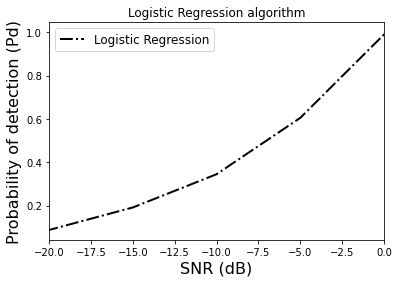

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [91]:
%matplotlib inline
fig = plt.figure()
# plt.plot(snrDB,pd_rnet,label = 'ResNet')
# plt.plot(snrDB,pd_lstm,label = 'LSTM')
plt.plot(snrDB,pd_lr,label = 'Logistic Regression',linestyle='dashdot',linewidth='2',c='black')
plt.xlim([-20,0])
plt.xlabel('SNR (dB)',fontsize=16)
plt.ylabel('Probability of detection (Pd)',fontsize=16)
plt.title("Logistic Regression algorithm")
plt.legend(fontsize=12)
plt.show()
fig.savefig('raw.eps')

# RandomForest

In [81]:
from sklearn.ensemble import RandomForestClassifier

pd_rf = np.ones(len(snrDB))
for i in range(len(snrDB)):
  
  featuresMatrix=createFeature(beta,snrDB[i])

  df_train,df_test = train_test_split(featuresMatrix, test_size=0.2, random_state=42)
  x_train, y_train = createTrainTest(df_train,num_sensors)
  x_test, y_test = createTrainTest(df_test,num_sensors)

  
  input_shape = (num_time_periods*num_sensors)
  
  x_train = x_train.reshape(x_train.shape[0], input_shape)
  
  x_train = x_train.astype("float32")
  y_train = y_train.astype("float32")

  x_test = x_test.reshape(x_test.shape[0], input_shape)

  x_test = x_test.astype("float32")
  y_test = y_test.astype("float32")
  model_rf=RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)
  model_rf.fit(x_train,y_train)
  y_pred=model_rf.predict_proba(x_test)[:,0]
  fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_pred,pos_label=0)
  pd_rf[i]=findPd(fpr_lr,tpr_lr)
  precision_rf=precision_score(y_test,y_pred.round())
  recall_rf=recall_score(y_test,y_pred.round())
  print(snrDB[i])
  print("Accuracy is",model_rf.score(x_test,y_test))
  print("probablity of detection is ",pd_rf[i])
  print("precision is",precision_rf)
  print("recall is",recall_rf)

20
Accuracy is 1.0
probablity of detection is  1.0
precision is 0.0
recall is 0.0
15
Accuracy is 1.0
probablity of detection is  1.0
precision is 0.0
recall is 0.0
10
Accuracy is 1.0
probablity of detection is  1.0
precision is 0.0
recall is 0.0
5
Accuracy is 1.0
probablity of detection is  1.0
precision is 0.0
recall is 0.0
0
Accuracy is 0.9525
probablity of detection is  0.994535519125683
precision is 0.05913978494623656
recall is 0.05069124423963134
-5
Accuracy is 0.8025
probablity of detection is  0.6262626262626263
precision is 0.22580645161290322
recall is 0.24257425742574257
-10
Accuracy is 0.68
probablity of detection is  0.37755102040816324
precision is 0.3316831683168317
recall is 0.3284313725490196
-15
Accuracy is 0.55
probablity of detection is  0.19369369369369369
precision is 0.38333333333333336
recall is 0.38764044943820225
-20
Accuracy is 0.535
probablity of detection is  0.09859154929577464
precision is 0.43349753694581283
recall is 0.47058823529411764


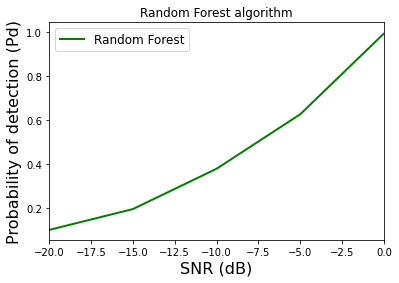

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [92]:
%matplotlib inline
fig = plt.figure()
# plt.plot(snrDB,pd_rnet,label = 'ResNet')
# plt.plot(snrDB,pd_lstm,label = 'LSTM')
plt.plot(snrDB,pd_rf,label = 'Random Forest',linewidth='2',c='g')
plt.xlim([-20,0])
plt.xlabel('SNR (dB)',fontsize=16)
plt.ylabel('Probability of detection (Pd)',fontsize=16)
plt.title("Random Forest algorithm")
plt.legend(fontsize=12)
plt.show()
fig.savefig('raw.eps')

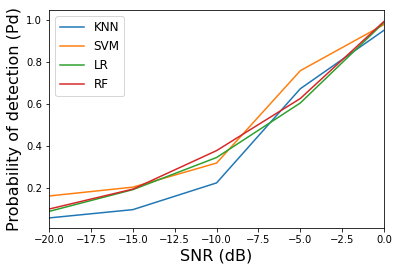

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [93]:
%matplotlib inline
fig = plt.figure()
# plt.plot(snrDB,pd_rnet,label = 'ResNet')
# plt.plot(snrDB,pd_lstm,label = 'LSTM')
plt.plot(snrDB,pd_knn,label = 'KNN')
plt.plot(snrDB,pd_svm,label = 'SVM')
plt.plot(snrDB,pd_lr,label = 'LR')
plt.plot(snrDB,pd_rf,label = 'RF')
plt.xlim([-20,0])
plt.xlabel('SNR (dB)',fontsize=16)
plt.ylabel('Probability of detection (Pd)',fontsize=16)
plt.legend(fontsize=12)
plt.show()
fig.savefig('raw.eps')

# DNN

In [46]:
#@title Model train/test  { form-width: "30%" }
def trainingModel(model,tcn=False):
  if tcn:
    model.compile(
    loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

    # Hyper-parameters
    BATCH_SIZE = 200
    EPOCHS = 5

    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model.fit(x_train,
                          y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,

                          validation_split=0.2,
                          verbose=0
                          )
    y_pred = model.predict(x_test)

    y_pred2=[]
    for i in y_pred:
      # print(i[0])
      if(i[0]>i[1]):
        y_pred2.append(i[1])
      else:
        y_pred2.append(i[1])
    y_test2=[]
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_pred2)
    return fpr_keras,tpr_keras

  # callbacks_list = [
  #     keras.callbacks.ModelCheckpoint(
  #         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
  #         monitor='val_loss', save_best_only=True),
  #     keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
  # ]

  model.compile(
      loss='binary_crossentropy',
                  optimizer='adam', metrics=['binary_accuracy'])

  # Hyper-parameters
  BATCH_SIZE = 10
  EPOCHS = 10

  # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
  history = model.fit(x_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                
                        validation_split=0.2,
                        verbose=0
                        )
  accuracy_results = model.evaluate(x_test, y_test)
  print("Accuracy :",accuracy_results)
  # %%

  # print("\n--- Learning curve of model training ---\n")

  # # summarize history for accuracy and loss
  # plt.figure(figsize=(6, 4))
  # plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
  # plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
  # plt.plot(history.history['loss'], "r--", label="Loss of training data")
  # plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
  # plt.title('Model Accuracy and Loss')
  # plt.ylabel('Accuracy and Loss')
  # plt.xlabel('Training Epoch')
  # plt.ylim(0)
  # plt.legend()
  # plt.show()

  #%%

  
  # y_test = np_utils.to_categorical(y_test, num_classes)

  # %%

  # print("\n--- Confusion matrix for test data ---\n")

  # y_pred_test = model_m.predict(x_test)
  # # Take the class with the highest probability from the test predictions
  # max_y_pred_test = np.argmax(y_pred_test, axis=1)
  # max_y_test = np.argmax(y_test, axis=1)

  # show_confusion_matrix(max_y_test, max_y_pred_test)

  # # %%

  # print("\n--- Classification report for test data ---\n")

  # print(classification_report(max_y_test, max_y_pred_test))
  
  # x_test, y_test = create_segments_and_labels(df_test,
  #                                             TIME_PERIODS,
  #                                             STEP_DISTANCE,
  #                                             'LABEL')
  # x_test = x_test.reshape(x_test.shape[0], input_shape)
  y_pred = model.predict(x_test)
  # if accuracy_results[1]<0.5:
  #   y_pred = 1-y_pred
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_pred)
  # plt.figure(1)
  # plt.plot(fpr_keras, tpr_keras)
  # plt.xlabel('False positive rate')
  # plt.ylabel('True positive rate')
  # plt.title('ROC curve')
  # plt.legend(loc='best')
  # plt.show()

  return fpr_keras,tpr_keras

# CNN MODEL

In [47]:
#@title CNN  { form-width: "30%" }
model_cnn = Sequential()
model_cnn.add(Reshape((num_sensors, 1), input_shape=(num_sensors,)))
model_cnn.add(Conv1D(50, 1, activation='relu', input_shape=(num_sensors,1)))
model_cnn.add(Conv1D(50, 1, activation='relu'))
model_cnn.add(MaxPooling1D(1))
model_cnn.add(Dense(50,activation='relu'))
model_cnn.add(Dense(50,activation='relu'))
model_cnn.add(GlobalAveragePooling1D())
model_cnn.add(Dense(num_classes, activation='sigmoid'))
model_cnn.save('CNN.h5')
print(model_cnn.summary())
# from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 4, 1)              0         
                                                                 
 conv1d (Conv1D)             (None, 4, 50)             100       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 50)             2550      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 50)            0         
 )                                                               
                                                                 
 dense (Dense)               (None, 4, 50)             2550      
                                                                 
 dense_1 (Dense)             (None, 4, 50)             2550      
                                                        

In [63]:
for i in range(len(snrDB)):
  
  featuresMatrix=createFeature(beta,snrDB[i])

  df_train,df_test = train_test_split(featuresMatrix, test_size=0.2, random_state=42)
  x_train, y_train = createTrainTest(df_train,num_sensors)
  x_test, y_test = createTrainTest(df_test,num_sensors)

  print(snrDB[i])
  input_shape = (num_time_periods*num_sensors)
  
  x_train = x_train.reshape(x_train.shape[0], input_shape)
  
  x_train = x_train.astype("float32")
  y_train = y_train.astype("float32")

  x_test = x_test.reshape(x_test.shape[0], input_shape)

  x_test = x_test.astype("float32")
  y_test = y_test.astype("float32")

  fpr_cnn,tpr_cnn = trainingModel(model_cnn)
  pd_cnn[i]=findPd(fpr_cnn,tpr_cnn)
  print("probablity of detection is",pd_cnn[i])

20
13/13 [==============================] - 0s 5ms/step - loss: 2.6135e-05 - binary_accuracy: 1.0000
Accuracy : [2.613478500279598e-05, 1.0]
probablity of detection is 1.0
15
13/13 [==============================] - 0s 4ms/step - loss: 1.1406e-07 - binary_accuracy: 1.0000
Accuracy : [1.140581105119054e-07, 1.0]
probablity of detection is 1.0
10
13/13 [==============================] - 1s 5ms/step - loss: 5.1441e-07 - binary_accuracy: 1.0000
Accuracy : [5.144086117070401e-07, 1.0]
probablity of detection is 1.0
5
13/13 [==============================] - 0s 3ms/step - loss: 0.0025 - binary_accuracy: 1.0000
Accuracy : [0.002470192266628146, 1.0]
probablity of detection is 1.0
0
13/13 [==============================] - 0s 3ms/step - loss: 0.1540 - binary_accuracy: 0.9325
Accuracy : [0.15402323007583618, 0.9325000047683716]
probablity of detection is 0.9760765550239234
-5
13/13 [==============================] - 0s 4ms/step - loss: 0.4230 - binary_accuracy: 0.8175
Accuracy : [0.422990888357

# MLP MODEL

In [49]:
#@title MLP  { form-width: "30%" }
# input_layer = keras.layers.Input(num_sensors,)

# # flatten/reshape because when multivariate all should be on the same axis 
# input_layer_flattened = keras.layers.Flatten()(input_layer)

# # layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
# layer_1 = keras.layers.Dense(500, activation='relu')(input_layer_flattened)

# # layer_2 = keras.layers.Dropout(0.2)(layer_1)
# layer_2 = keras.layers.Dense(500, activation='relu')(layer_1)

# # layer_3 = keras.layers.Dropout(0.2)(layer_2)
# layer_3 = keras.layers.Dense(500, activation='relu')(layer_2)

# # output_layer = keras.layers.Dropout(0.3)(layer_3)
# output_layer = keras.layers.Dense(1, activation='sigmoid')(layer_3)

# model_mlp = keras.models.Model(inputs=input_layer, outputs=output_layer)

# model_m.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model_mlp = Sequential()
model_mlp.add(keras.Input(shape=(num_sensors,)))
# model_mlp.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
# model_mlp.add(Dense(3,activation='relu'))
model_mlp.add(Dense(100,activation='relu'))
model_mlp.add(Dense(100,activation='relu'))
model_mlp.add(Dense(100,activation='relu'))
model_mlp.add(Dense(1,activation='sigmoid'))
print(model_mlp.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               500       
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
for i in range(len(snrDB)):
  
  featuresMatrix=createFeature(beta,snrDB[i])

  df_train,df_test = train_test_split(featuresMatrix, test_size=0.2, random_state=42)
  x_train, y_train = createTrainTest(df_train,num_sensors)
  x_test, y_test = createTrainTest(df_test,num_sensors)

  print(snrDB[i])
  input_shape = (num_time_periods*num_sensors)
  
  x_train = x_train.reshape(x_train.shape[0], input_shape)
  
  x_train = x_train.astype("float32")
  y_train = y_train.astype("float32")

  x_test = x_test.reshape(x_test.shape[0], input_shape)

  x_test = x_test.astype("float32")
  y_test = y_test.astype("float32")
  
  fpr_mlp,tpr_mlp = trainingModel(model_mlp)
  pd_mlp[i]=(findPd(fpr_mlp,tpr_mlp))
  print("probability od detection is ",pd_mlp[i])

20
13/13 [==============================] - 1s 4ms/step - loss: 8.2554e-08 - binary_accuracy: 1.0000
Accuracy : [8.255396721779107e-08, 1.0]
probability od detection is  1.0
15
13/13 [==============================] - 1s 2ms/step - loss: 2.9328e-10 - binary_accuracy: 1.0000
Accuracy : [2.9327651418498135e-10, 1.0]
probability od detection is  1.0
10
13/13 [==============================] - 1s 2ms/step - loss: 7.3249e-09 - binary_accuracy: 1.0000
Accuracy : [7.324907791428359e-09, 1.0]
probability od detection is  1.0
5
13/13 [==============================] - 0s 2ms/step - loss: 8.3994e-04 - binary_accuracy: 1.0000
Accuracy : [0.0008399374783039093, 1.0]
probability od detection is  1.0
0
13/13 [==============================] - 0s 2ms/step - loss: 0.1020 - binary_accuracy: 0.9625
Accuracy : [0.10197940468788147, 0.9624999761581421]
probability od detection is  0.9853658536585366
-5
13/13 [==============================] - 1s 2ms/step - loss: 0.3875 - binary_accuracy: 0.8075
Accuracy :

# ResNet MODEL

In [51]:
#@title RESNET  { form-width: "30%" }
n_feature_maps = 50

input_layer = keras.layers.Input(num_sensors,)

# BLOCK 1
reshape = keras.layers.Reshape((1,num_sensors), input_shape=(num_sensors,))(input_layer)
conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(reshape)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(reshape)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_2 = keras.layers.add([shortcut_y, conv_z])
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)

output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)

# FINAL

gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

output_layer = keras.layers.Dense(1, activation='sigmoid')(gap_layer)

model_rnet = keras.models.Model(inputs=input_layer, outputs=output_layer)
model_rnet.save('RNET.h5')
# model_m.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

C:\Users\PRIYA LAKKU\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [69]:
for i in range(len(snrDB)):
  
  featuresMatrix=createFeature(beta,snrDB[i])

  df_train,df_test = train_test_split(featuresMatrix, test_size=0.2, random_state=42)
  x_train, y_train = createTrainTest(df_train,num_sensors)
  x_test, y_test = createTrainTest(df_test,num_sensors)

  print(snrDB[i])
  input_shape = (num_time_periods*num_sensors)
  
  x_train = x_train.reshape(x_train.shape[0], input_shape)
  
  x_train = x_train.astype("float32")
  y_train = y_train.astype("float32")

  x_test = x_test.reshape(x_test.shape[0], input_shape)

  x_test = x_test.astype("float32")
  y_test = y_test.astype("float32")
  
  fpr_rnet,tpr_rnet = trainingModel(model_rnet)
  pd_rnet[i]=(findPd(fpr_rnet,tpr_rnet))
  print("probability of detection is",pd_rnet[i])

20
13/13 [==============================] - 1s 4ms/step - loss: 1.6534e-04 - binary_accuracy: 1.0000
Accuracy : [0.00016533609596081078, 1.0]
probability of detection is 1.0
15
13/13 [==============================] - 1s 3ms/step - loss: 2.5897e-05 - binary_accuracy: 1.0000
Accuracy : [2.589678842923604e-05, 1.0]
probability of detection is 1.0
10
13/13 [==============================] - 1s 3ms/step - loss: 2.6791e-06 - binary_accuracy: 1.0000
Accuracy : [2.679137651284691e-06, 1.0]
probability of detection is 1.0
5
13/13 [==============================] - 1s 5ms/step - loss: 0.0109 - binary_accuracy: 0.9975
Accuracy : [0.010908696800470352, 0.9975000023841858]
probability of detection is 1.0
0
13/13 [==============================] - 1s 4ms/step - loss: 0.0915 - binary_accuracy: 0.9550
Accuracy : [0.09152323007583618, 0.9549999833106995]
probability of detection is 0.985781990521327
-5
13/13 [==============================] - 1s 3ms/step - loss: 0.4167 - binary_accuracy: 0.8125
Accura

# LSTM MODEL

In [53]:
#@title LSTM  { form-width: "30%" }

from keras.regularizers import l2
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time


N = num_sensors                 # number of features
EPOCH = 50                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

model_lstm = Sequential()
model_lstm.add(Reshape((1,num_sensors), input_shape=(num_sensors,)))
model_lstm.add(LSTM(input_shape=(1,num_sensors), units=8,
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(units=8,
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(units=8,
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(units=1, activation='sigmoid'))
model_lstm.save('LSTM.h5')
# model_m.summary()
from tensorflow.keras.utils import plot_model
# plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [75]:
for i in range(len(snrDB)):
  
  featuresMatrix=createFeature(beta,snrDB[i])

  df_train,df_test = train_test_split(featuresMatrix, test_size=0.2, random_state=42)
  x_train, y_train = createTrainTest(df_train,num_sensors)
  x_test, y_test = createTrainTest(df_test,num_sensors)

  print(snrDB[i])
  input_shape = (num_time_periods*num_sensors)
  
  x_train = x_train.reshape(x_train.shape[0], input_shape)
  
  x_train = x_train.astype("float32")
  y_train = y_train.astype("float32")

  x_test = x_test.reshape(x_test.shape[0], input_shape)

  x_test = x_test.astype("float32")
  y_test = y_test.astype("float32")
  
  fpr_lstm,tpr_lstm = trainingModel(model_lstm)
  pd_lstm[i]=(findPd(fpr_lstm,tpr_lstm))
  print("probability of detection is",pd_lstm[i])

20
13/13 [==============================] - 1s 3ms/step - loss: 0.0021 - binary_accuracy: 1.0000
Accuracy : [0.0020632974337786436, 1.0]
probability of detection is 1.0
15
13/13 [==============================] - 1s 3ms/step - loss: 0.0018 - binary_accuracy: 1.0000
Accuracy : [0.0017612699884921312, 1.0]
probability of detection is 1.0
10
13/13 [==============================] - 1s 2ms/step - loss: 0.0018 - binary_accuracy: 1.0000
Accuracy : [0.0017771355342119932, 1.0]
probability of detection is 1.0
5
13/13 [==============================] - 1s 2ms/step - loss: 0.0033 - binary_accuracy: 1.0000
Accuracy : [0.003251518588513136, 1.0]
probability of detection is 1.0
0
13/13 [==============================] - 1s 3ms/step - loss: 0.5822 - binary_accuracy: 0.7475
Accuracy : [0.582232654094696, 0.7475000023841858]
probability of detection is 0.995049504950495
-5
13/13 [==============================] - 2s 3ms/step - loss: 0.4052 - binary_accuracy: 0.8100
Accuracy : [0.405216246843338, 0.810

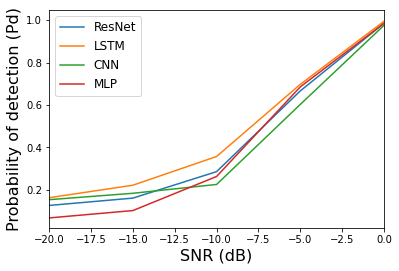

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [94]:
#plt.plot(snrDB,pd_cnn_gp,label = 'CNN_gp')
# plt.plot(snrDB,pd_cnn_de,label = 'CNN_de')
# plt.plot(snrDB,pd_cnn_lp,label = 'CNN_lp')
# plt.plot(snrDB,pd_cnn,label = 'CNN_raw')
# plt.plot(snrDB,pd_lstm_gp,label = 'lstm')
# plt.plot(snrDB,pd_mlp_gp,label = 'MLP')
%matplotlib inline
fig = plt.figure()
plt.plot(snrDB,pd_rnet,label = 'ResNet')
plt.plot(snrDB,pd_lstm,label = 'LSTM')
plt.plot(snrDB, pd_cnn, label = 'CNN') #plt.plot(snrDB_new,pd_lp,label = 'LP')
plt.plot(snrDB,pd_mlp,label = 'MLP')
# plt.plot(snrDB_new,pd_tcn,label = 'TCN')
plt.xlim([-20,0])
plt.xlabel('SNR (dB)',fontsize=16)
plt.ylabel('Probability of detection (Pd)',fontsize=16)
# plt.plot(snrDB_tcn,pd_tcn_gp,label = 'tcn')
# plt.plot(snrDB,pd_fcn_gp,label = 'FCN')
plt.legend(fontsize=12)
plt.show()
fig.savefig('raw.eps')